In [15]:
import numpy as np
import pandas as pd

# ============================================================
# ① 周期的波形のサンプルデータを生成
# ============================================================
def generate_periodic_sample(
    fs: float = 2000.0,
    duration_s: float = 5.0,
    freqs_hz=(50.0, 120.0),
    amps=(1.0, 0.6),
    phases_rad=None,
    dc_offset: float = 0.0,
    noise_std: float = 0.1,
    n_sensors: int = 3,
    sensor_scale=None,
    sensor_phase_shift_rad=None,
    seed: int = 0,
    time_col: str = "t",
    sensor_prefix: str = "s",
) -> pd.DataFrame:
    """
    周期信号（複数正弦の和）+ DC + ノイズ を生成して DataFrame で返す。
    出力列: [time_col, s1, s2, ...]
    """
    rng = np.random.default_rng(seed)

    freqs_hz = np.asarray(freqs_hz, dtype=float)
    amps = np.asarray(amps, dtype=float)
    if phases_rad is None:
        phases_rad = np.zeros_like(freqs_hz, dtype=float)
    phases_rad = np.asarray(phases_rad, dtype=float)

    if sensor_scale is None:
        sensor_scale = np.ones(n_sensors, dtype=float)
    sensor_scale = np.asarray(sensor_scale, dtype=float)

    if sensor_phase_shift_rad is None:
        sensor_phase_shift_rad = np.zeros(n_sensors, dtype=float)
    sensor_phase_shift_rad = np.asarray(sensor_phase_shift_rad, dtype=float)

    N = int(round(fs * duration_s))
    t = np.arange(N, dtype=float) / fs

    # 基本波形（1本）
    base = np.full(N, dc_offset, dtype=float)
    for f, a, ph in zip(freqs_hz, amps, phases_rad):
        base += a * np.sin(2.0 * np.pi * f * t + ph)

    data = {time_col: t}
    for i in range(n_sensors):
        if sensor_phase_shift_rad[i] == 0.0:
            sig = sensor_scale[i] * base
        else:
            sig = np.full(N, dc_offset, dtype=float)
            for f, a, ph in zip(freqs_hz, amps, phases_rad):
                sig += sensor_scale[i] * a * np.sin(2.0 * np.pi * f * t + ph + sensor_phase_shift_rad[i])

        sig = sig + noise_std * rng.normal(size=N)
        data[f"{sensor_prefix}{i+1}"] = sig

    return pd.DataFrame(data)


# ============================================================
# ② 連続データを任意の窓ごとに「1行1窓」に変換（wide DataFrame）
# ============================================================
def to_window_wide_df(
    df: pd.DataFrame,
    sensor_cols,
    win_len: int,
    step: int,
    time_col: str = "t",
    include_t_center: bool = True,
) -> pd.DataFrame:
    """
    df の連続データを 1行=1窓 の wide DataFrame に変換して返す。
    列名: s1_000, s1_001, ..., s2_000, ...
    先頭に t_center 列を付ける（include_t_center=True の場合）。
    """
    if isinstance(sensor_cols, str):
        sensor_cols = [sensor_cols]

    x = df[sensor_cols].to_numpy(dtype=float)  # (N, S)
    N, S = x.shape

    if time_col in df.columns:
        t = df[time_col].to_numpy(dtype=float)
    else:
        t = np.arange(N, dtype=float)

    if N < win_len:
        raise ValueError("データ長 N が win_len より短いです。")

    starts = np.arange(0, N - win_len + 1, step, dtype=int)
    n_win = len(starts)

    # wide配列（sensor-major：s1全部→s2全部→...）
    wide = np.empty((n_win, win_len * S), dtype=float)
    if include_t_center:
        t_centers = np.empty(n_win, dtype=float)

    half = (win_len - 1) / 2.0
    for i, st in enumerate(starts):
        seg = x[st:st + win_len, :]          # (win_len, S)
        wide[i, :] = seg.T.reshape(-1)       # (S*win_len,)
        if include_t_center:
            t_centers[i] = t[st + int(round(half))]

    cols = []
    for s in sensor_cols:
        cols += [f"{s}_{k:03d}" for k in range(win_len)]

    wide_df = pd.DataFrame(wide, columns=cols)
    if include_t_center:
        wide_df.insert(0, "t_center", t_centers)

    return wide_df


# ============================================================
# ②の wide DataFrame を「(n_win, L, S)」に戻す（③で使用）
# ============================================================
def wide_df_to_windows(
    wide_df: pd.DataFrame,
    sensor_cols,
    win_len: int,
    t_center_col: str = "t_center",
):
    """
    1行=1窓の wide_df から windows 配列 (n_win, win_len, S) を復元する。
    t_center 列があれば t_centers も返す（無ければ None）。
    """
    if isinstance(sensor_cols, str):
        sensor_cols = [sensor_cols]

    n_win = wide_df.shape[0]
    S = len(sensor_cols)

    windows = np.empty((n_win, win_len, S), dtype=float)

    for si, sname in enumerate(sensor_cols):
        cols = [f"{sname}_{k:03d}" for k in range(win_len)]
        missing = [c for c in cols if c not in wide_df.columns]
        if missing:
            raise ValueError(f"wide_df に必要な列がありません（例）: {missing[:3]}")
        windows[:, :, si] = wide_df[cols].to_numpy(dtype=float)

    t_centers = None
    if t_center_col in wide_df.columns:
        t_centers = wide_df[t_center_col].to_numpy(dtype=float)

    return windows, t_centers


# ============================================================
# ③ windows をFFT特徴量へ（DataFrameで返す・metaは作らない）
# ============================================================
def fft_features_from_windows_df(
    windows: np.ndarray,              # (n_win, L, S)
    fs: float | None,                 # fs不明なら None（周波数は正規化: cycles/sample）
    k: int = 20,                      # DC除外で 1..k を特徴にする
    use_hann: bool = True,
    amp_correction: str = "hann",     # "none" / "n" / "hann"
    feature_mode: str = "amplitude",  # "amplitude" / "power"
    use_log1p: bool = True,
    add_mean: bool = True,
    sensor_names=None,                # 例: ["s1","s2","s3"]（Noneなら s0,s1,...）
):
    """
    window配列からFFT特徴量 DataFrame を作る（metaは返さない）。

    戻り値:
      X_df : (n_win, n_features) の DataFrame
      freq : rfftの周波数軸
             - fs指定: Hz
             - fs=None: cycles/sample（正規化周波数）
    列名の例（add_mean=True, feature_mode="amplitude"）:
      s1_mean, s1_amp_f001, ..., s1_amp_f020, s2_mean, s2_amp_f001, ...
    """
    if windows.ndim != 3:
        raise ValueError("windows は (n_win, L, S) の3次元配列を想定しています。")

    n_win, L, S = windows.shape
    if k < 1 or k > (L // 2):
        raise ValueError("k は 1 以上かつ L//2 以下にしてください（rfftの範囲内）。")

    if sensor_names is None:
        sensor_names = [f"s{i}" for i in range(S)]
    if len(sensor_names) != S:
        raise ValueError("sensor_names の長さが windows のセンサ数 S と一致しません。")

    # 窓関数
    w = np.hanning(L).astype(float) if use_hann else np.ones(L, dtype=float)
    w_sum = float(np.sum(w))

    # 周波数軸
    if fs is None:
        freq = np.fft.rfftfreq(L, d=1.0)          # cycles/sample
        freq_unit = "cyc"
    else:
        freq = np.fft.rfftfreq(L, d=1.0 / fs)     # Hz
        freq_unit = "hz"

    # FFT
    xw = windows * w[None, :, None]
    X = np.fft.rfft(xw, axis=1)
    mag = np.abs(X)

    # 振幅補正（特徴量としての目安）
    if amp_correction == "none":
        amp = mag
    elif amp_correction == "n":
        amp = (2.0 / L) * mag
    elif amp_correction == "hann":
        amp = (2.0 / w_sum) * mag
    else:
        raise ValueError("amp_correction は 'none' / 'n' / 'hann' のいずれかです。")

    # 特徴モード
    if feature_mode == "amplitude":
        core0 = amp
        kind = "amp"
    elif feature_mode == "power":
        core0 = amp ** 2
        kind = "pow"
    else:
        raise ValueError("feature_mode は 'amplitude' / 'power' のいずれかです。")

    # DC除外で 1..k
    core = core0[:, 1:k+1, :]  # (n_win, k, S)

    if use_log1p:
        core = np.log1p(core)
        kind = f"log1p_{kind}"

    # DataFrame化（センサごとに [mean, f001..fK] を並べる）
    cols = []
    blocks = []

    for si, sname in enumerate(sensor_names):
        if add_mean:
            mu = np.mean(windows[:, :, si], axis=1, keepdims=True)  # (n_win, 1)
            blocks.append(mu)
            cols.append(f"{sname}_mean")

        blocks.append(core[:, :, si])  # (n_win, k)
        for b in range(1, k + 1):
            # 「何番目のビンか」を列名に残す（周波数値を列名に埋めない＝fs違いでも安全）
            # 必要なら freq[b] を使って別に参照できる
            cols.append(f"{sname}_{kind}_{freq_unit}{b:03d}")

    X_feat = np.concatenate(blocks, axis=1)
    X_df = pd.DataFrame(X_feat, columns=cols)

    return X_df, freq



In [16]:
# ============================================================
# 実行例（パラメータ設定に注釈コメント付き）
# ============================================================

# ① 周期データ生成
df = generate_periodic_sample(
    fs=2000.0,                 # サンプリング周波数[Hz]（1秒あたり何点取るか）
    duration_s=6.0,            # データ長[秒]（合計で fs*duration_s 点の時系列になる）

    freqs_hz=(50.0, 120.0),    # 含めたい周波数[Hz]（ここでは50Hzと120Hzの正弦波を足す）
    amps=(1.0, 0.5),           # 各周波数の振幅（50Hzの振幅=1.0、120Hzの振幅=0.5）
    phases_rad=(0.0, 0.6),     # 各周波数の位相[rad]（開始位置のずれ）

    dc_offset=0.2,             # 直流成分（平均値の持ち上げ=上下シフト）
    noise_std=0.08,            # ノイズの標準偏差（大きいほど波形がばらつく）

    n_sensors=3,               # センサ本数（s1, s2, s3 を作る）
    sensor_scale=(1.0, 0.9, 1.4),           # センサごとの全体スケール（s2は0.9倍、s3は0.7倍など）
    sensor_phase_shift_rad=(0.0, 0.3, -0.1), # センサごとの追加位相シフト[rad]（センサ間で形が少しずれる想定）

    seed=0                     # 乱数シード（同じ値なら毎回同じデータが出る）
)

# ② 連続時系列 → 1行=1窓（wide DataFrame化）
sensor_cols = ["s1", "s2", "s3"]  # 窓化したい列（センサ列）
WIN = 256                         # 窓長L（1窓=256点 → 1行に256点×3センサが並ぶ）
STEP = 256                        # 窓の移動幅（256なら非重複、128なら50%重複）

wide_df = to_window_wide_df(
    df,
    sensor_cols=sensor_cols,
    win_len=WIN,                   # 1窓あたりのサンプル数
    step=STEP,                     # 窓のずらし幅
    include_t_center=True           # 各窓の代表時刻 t_center を列として付与（後で時系列に戻して見るため）
)

# ③ （wide_dfを読み込んだ想定で）windows配列へ復元してFFT特徴量化
windows, t_centers = wide_df_to_windows(
    wide_df,
    sensor_cols=sensor_cols,        # wide_df内の列名 s1_000... を復元するために必要
    win_len=WIN,                    # 何点が1窓か（列数の復元に必要）
    t_center_col="t_center"         # 代表時刻列の名前
)

K = 30  # 使う周波数ビン数（DC=0Hzを除外して 1..K を特徴にする）
        # 周波数分解能は df = fs/WIN [Hz] なので、ここでは 2000/256 ≈ 7.8125Hz刻み
        # つまり K=30 なら最大で 約 30*7.8125 ≈ 234Hz 付近までを特徴に含める

X_feat, freq= fft_features_from_windows_df(
    windows,
    fs=2000.0,                      # サンプリング周波数[Hz]（周波数軸の計算に必須）
    k=K,                             # 周波数成分の個数（DC除外で1..K）
    use_hann=True,                   # 窓関数（端の不連続を弱め、特徴量のブレを減らす）
    amp_correction="none",           # 振幅補正の方法
                                     #  - "none": 補正なし（FFTの絶対値そのまま）
                                     #  - "n":    (2/L)*|FFT|（窓なし前提の簡易補正）
                                     #  - "hann": (2/sum(hann))*|FFT|（ハニング窓に合わせた簡易補正）
    feature_mode="power",        # 特徴量の定義
                                     #  - "amplitude": 振幅（大きさ）
                                     #  - "power":     振幅^2（エネルギー寄り）

    use_log1p=True,                  # log(1+x) を取る（極端に大きい成分の影響を抑えて学習を安定化）
    add_mean=True                    # 各窓の平均値（上下シフト）を周波数特徴とは別に追加する
                                     # DC成分(0Hz)は窓関数で歪むので、「平均」は時間領域から別で計算して入れる
)

print("df:", df.shape)
print("wide_df:", wide_df.shape)            # (窓数, 1 + センサ数*WIN)
print("windows:", windows.shape)            # (窓数, WIN, センサ数)
print("X_feat:", X_feat.shape)              # (窓数, センサ数*(K + (add_mean?1:0)))

# 列名例の表示
print("X_feat columns:", X_feat.columns.tolist())


df: (12000, 4)
wide_df: (46, 769)
windows: (46, 256, 3)
X_feat: (46, 93)
X_feat columns: ['s0_mean', 's0_log1p_pow_hz001', 's0_log1p_pow_hz002', 's0_log1p_pow_hz003', 's0_log1p_pow_hz004', 's0_log1p_pow_hz005', 's0_log1p_pow_hz006', 's0_log1p_pow_hz007', 's0_log1p_pow_hz008', 's0_log1p_pow_hz009', 's0_log1p_pow_hz010', 's0_log1p_pow_hz011', 's0_log1p_pow_hz012', 's0_log1p_pow_hz013', 's0_log1p_pow_hz014', 's0_log1p_pow_hz015', 's0_log1p_pow_hz016', 's0_log1p_pow_hz017', 's0_log1p_pow_hz018', 's0_log1p_pow_hz019', 's0_log1p_pow_hz020', 's0_log1p_pow_hz021', 's0_log1p_pow_hz022', 's0_log1p_pow_hz023', 's0_log1p_pow_hz024', 's0_log1p_pow_hz025', 's0_log1p_pow_hz026', 's0_log1p_pow_hz027', 's0_log1p_pow_hz028', 's0_log1p_pow_hz029', 's0_log1p_pow_hz030', 's1_mean', 's1_log1p_pow_hz001', 's1_log1p_pow_hz002', 's1_log1p_pow_hz003', 's1_log1p_pow_hz004', 's1_log1p_pow_hz005', 's1_log1p_pow_hz006', 's1_log1p_pow_hz007', 's1_log1p_pow_hz008', 's1_log1p_pow_hz009', 's1_log1p_pow_hz010', 's1_log1

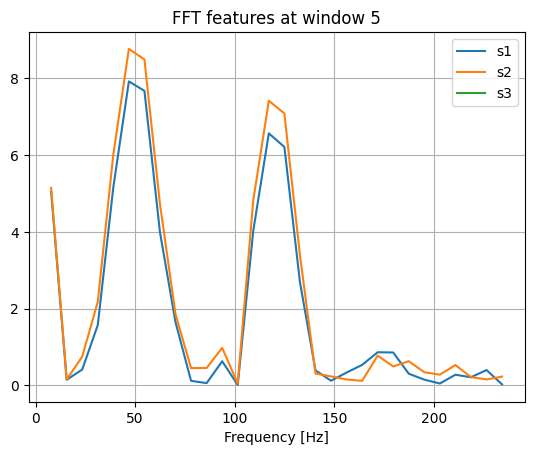

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import re

# ===== どれか1つ指定 =====
win_i = 5          # ←「窓番号」で指定（0,1,2,...）
# target_t = 2.5   # ←「時刻」で指定したいなら（t_centers がある場合）こちらを使う

# 時刻指定がある場合は、最も近い窓を選ぶ
if "target_t" in globals() and t_centers is not None:
    win_i = int(np.argmin(np.abs(np.asarray(t_centers) - float(target_t))))

plt.figure()

for s in sensor_cols:
    # そのセンサの「周波数ビン列」だけ抜き出す（例: s1_..._hz001 ～ hz030）
    cols = [c for c in X_feat.columns
            if c.startswith(f"{s}_") and re.search(r"hz\d{3}$", c)]

    # ビン番号(001,002,...)で並べ替え
    cols = sorted(cols, key=lambda c: int(re.search(r"(\d{3})$", c).group(1)))

    # 対応する周波数（freq[b] を使う）
    bins = np.array([int(re.search(r"(\d{3})$", c).group(1)) for c in cols], dtype=int)
    f = np.asarray(freq)[bins]  # [Hz]（fsを入れて作っている前提）

    # その窓(win_i)の周波数成分（※いまは log1p(power) の値）
    y = X_feat.loc[win_i, cols].to_numpy(float)

    # 元の power に戻したいなら（use_log1p=True の場合）
    # y = np.expm1(y)

    plt.plot(f, y, label=s)

plt.title(f"FFT features at window {win_i}")
plt.xlabel("Frequency [Hz]")
plt.grid(True)
plt.legend()
plt.show()
